In [1]:
# importing data and auxiliar functions

import saopaulo.sp_grid as gr
import bikescience.distributions as dist
import saopaulo.cycling_potential as cp
import saopaulo.choropleth as choro
from bikescience.slope import plot_slope, plot_slopes, split_route
from shapely.geometry import LineString
import ast

from math import floor

import folium
import pandas as pd
import geopandas as gpd
from statistics import stdev
from ipywidgets import interact_manual, widgets, fixed
from IPython.core.display import display, HTML, clear_output
import matplotlib.pyplot as plt
import matplotlib.ticker as tkr
import warnings
import requests
import os
warnings.simplefilter('ignore')
import time
import scipy.stats as st

# read routes files and join with general trips file
od_trips = pd.read_csv('../data/sao-paulo/od/OD_2017.csv')
od_trips.columns = [c[: c.index(',')] for c in od_trips.columns]
od_trips.set_index('ID_ORDEM', inplace=True, drop=False)

zone_shp = gpd.read_file('../data/sao-paulo/od/shapes/Zonas_2017_region.shp')
zone_shp.crs = {'init': 'epsg:31983'}  
zone_shp.to_crs(epsg='4326', inplace=True)

routes_car = pd.read_csv('../data/sao-paulo/rotas-migracao/new_routes_cars.csv')
routes_car.set_index('trip_id', inplace=True, drop=False)
routes_car = routes_car.join(other = od_trips, how = 'left')
routes_car = gpd.GeoDataFrame(routes_car, crs={'init': 'epsg:4326'}, 
                              geometry=[LineString(ast.literal_eval(r)) for r in routes_car.route])
routes_car['length'] = routes_car['geometry'].length * 100000

the_grid = gr.create(n=10, west_offset=-0.15, east_offset=0.23, north_offset=0.19, south_offset=-0.46)

/home/pedro/.local/lib/python3.8/site-packages/geopandas/_compat.py:106: UserWarning: The Shapely GEOS version (3.8.0-CAPI-1.13.1 ) is incompatible with the GEOS version PyGEOS was compiled with (3.9.0-CAPI-1.16.2). Conversions between both will be slow.
  warnings.warn(
/usr/lib/python3/dist-packages/requests/__init__.py:89: RequestsDependencyWarning: urllib3 (1.26.5) or chardet (3.0.4) doesn't match a supported version!
  warnings.warn("urllib3 ({}) or chardet ({}) doesn't match a supported "


In [2]:
cp_list = []

for i, r in routes_car.iterrows():
    if (i % 50 == 0 and (r['MUNI_O'] == 36 or r['MUNI_D'] == 36)):
        try:
            pot_d, pot_a, pot_i = cp.cycling_potential_variables(r)
            cp_list.append(['car', i, pot_d, pot_a, pot_i, 0, r['FE_VIA'], r['SEXO'], r['geometry']])
        except:
            print(i, '- broken case')

In [3]:
columns = ['modal', 'trip_id', 'distance_potential', 'age_potential', 'inclination_potential', 'is_bike', 'fe_via', 'sexo', 'geometry']
df_cycling_potential = pd.DataFrame(data = cp_list, columns = columns)

In [4]:
def plot_route_potential (id_route):
    r = routes_car.loc[routes_car['ID_ORDEM'] == id_route].iloc[0]
    r_split = split_route(r['geometry'], 10)
    
    fmap = gr.map_around_sp(the_grid=None,zoom=15,plot_grid=False)
    plot_slope(fmap, r['geometry'], 'line')
    display(fmap)
    

    heights = [line[0].coords[0][2] for line in r_split]
    slopes = [line[1] for line in r_split]
    lengths = [i * 10 for i in range(len(heights))]

    plt.figure(figsize=(15,5))
    plt.plot(lengths, heights, label='altitude')
    plt.ylabel('altitude (metros)')
    plt.xlabel('metros')
    #plt.savefig('../pagina_web/images/altitude_' + r['ID_ORDEM'])
    plt.show()

    pos_s = []
    for s in slopes:
        if s > 0:
            pos_s.append(s)
    plt.figure(figsize=(15,5))
    plt.hist(bins=range(1, round(max(pos_s)) + 1),x=[round(s) for s in pos_s], weights = [10]*len(pos_s))
    plt.title('Metros percorridos em cada inclinação)')
    plt.xlabel('declividade')
    plt.ylabel('metros percorridos')
    #plt.savefig('../pagina_web/images/inclinacao_' + r['ID_ORDEM'])
    plt.show()

    pot = cp.cycling_potential_variables(r)
    print('Distance potential:    ', pot[0], '\tDistance: ', r['length'])
    print('Age potential:         ', pot[1], '\tAge:      ', r['IDADE'])
    print('Inclination potential: ', pot[2])
    print('\nGender:')
    print('1 = M, 2 = F           ', r['SEXO'])

In [5]:
def generate_images (route, trip_id):
    r_split = split_route(route, 10)

    heights = [line[0].coords[0][2] for line in r_split]
    slopes = [line[1] for line in r_split]
    lengths = [i * 10 for i in range(len(heights))]

    plt.figure(figsize=(15,5))
    plt.plot(lengths, heights, label='altitude')
    plt.ylabel('altitude (metros)')
    plt.xlabel('metros')
    plt.savefig('../pagina_web/images/altitude_' + trip_id)
    #plt.show()

    slopes_positive = []
    for s in slopes:
        if s > 0:
            slopes_positive.append(s)
    plt.figure(figsize=(15,5))
    plt.hist(bins=range(0, round(max(slopes)) + 1),
             x=[round(s) for s in slopes_positive], weights = [10]*len(slopes_positive))
    plt.title('Metros percorridos em cada nível de inclinação')
    plt.xlabel('inclinação (%)')
    plt.ylabel('metros percorridos')
    plt.savefig('../pagina_web/images/inclinacao_' + trip_id)

def route_to_json (route):
    json = """
    {
        "id": " """ + str(int(route['trip_id'])) + """ ",
        "distance": " """ + str(round(route['geometry'].length * 100000)) + """ ",
        "route":
        [
    """
    stretchs_slope = split_route(route['geometry'], 100, False)
    for s in stretchs_slope:
        if s[1] > 7:
            color='black'
        elif s[1] > 5:
            color='#982123'
        elif s[1] > 3:
            color='#D03F2E'
        elif s[1] > 1:
            color='#F1C359'
        elif s[1] > -1:
            color='yellow'
        elif s[1] > -3:
            color='#94C280'
        elif s[1] > -5:
            color='#0C9CB4'
        else:
            color='#025189'
        #geoj = folium.GeoJson(s[0], control=False, style_function=lambda style, color=color :{'color': color, 'weight': 3})
        json += \
            """
    {
        "type": "Feature",
        "properties": {
            "color": " """ + color + """ "
        },
        "geometry": {
            "type": "LineString",
            "coordinates": 
            [
            """
        for p in range(len(s[0].coords)):
            json += '[' + str(s[0].coords[p][0]) + ', ' + str(s[0].coords[p][1]) + ']'
            if (p < len(s[0].coords)):
                json += ','
            json += '\n'

        json += '] \n } \n },'
    json += '\n ] }'
    return json

#route_to_json (route)
#generate_images (route['geometry'], str(round(route['trip_id'])))

In [6]:
routes_sample = [74750, 63850, 41500, 102550, 43650, 123450, 76450, 24500]
json='var routes = ['
for i in routes_sample:
    route = routes_car.loc[routes_car['ID_ORDEM'] == i].iloc[0]
    #generate_images (route['geometry'], str(i))
    json += route_to_json (route)
    json += ','
json += \
"""
]

load_routes(routes)
"""
with open("Output.txt", "w") as text_file:
    text_file.write(json)

In [7]:
def filter_potential_widgets():
    # transform the lambda code in string, so we can pass as a string widget
    #pass the parameters as hidden widgets
    im = interact_manual(
        filter_potential,
        total_potential = widgets.FloatRangeSlider(
            value=[0.9, +1.],
            min=0, max=1., step=0.05,
            description='Final Potential:\t'
        ),
        distance_potential = widgets.FloatRangeSlider(
            value=[0, +1.],
            min=0, max=1., step=0.05,
            description='Distance Potential:\t'
        ),
        inclination_potential = widgets.FloatRangeSlider(
            value=[0, +1.],
            min=0, max=1., step=0.05,
            description='Inclination Potential:\t'
        ),
        age_potential = widgets.FloatRangeSlider(
            value=[0, +1.],
            min=0, max=1., step=0.05,
            description='Age Potential:\t'
        ),
        plot_map = widgets.Checkbox(value=True, description = 'Gerar mapa')
    )
    im.widget.children[5].description = 'Filtrar viagens'

def plot_filter_trips(df):
    fmap = gr.map_around_sp(the_grid=None,zoom=15,plot_grid=False)
    choro.plot_zones(fmap, zone_shp, lambda x : 0.01, 'green', plot_rmsp = False)
    for _, r in df.iterrows():
        try:
            plot_slope(fmap, r['geometry'], 100)
            tooltip_route=folium.features.Tooltip(text = ' id:\t' + str(r['trip_id']) + 
                                                  '\n fe_via:\t' + str(r['fe_via']) + 
                                                  '\n distance:\t' + str(round(r['geometry'].length * 100000)) +
                                                  '\n sexo:\t' + str(r['sexo']))
            folium.GeoJson(r['geometry'],
                           style_function = lambda x : {'opacity': 0, 'fillOpacity': 0},
                           tooltip = tooltip_route).add_to(fmap)
        except:
            print(_)
    display(fmap)
    
    
def filter_potential(total_potential, distance_potential, age_potential, inclination_potential, plot_map = False):    
    aux = df_cycling_potential
    aux['total'] = (aux['age_potential'] + aux['distance_potential'] + aux['inclination_potential']) / 3
    aux = aux.loc[aux['age_potential'] >= age_potential[0]]
    aux = aux.loc[aux['age_potential'] <= age_potential[1]]
    aux = aux.loc[aux['distance_potential'] >= distance_potential[0]]
    aux = aux.loc[aux['distance_potential'] <= distance_potential[1]]
    aux = aux.loc[aux['inclination_potential'] >= inclination_potential[0]]
    aux = aux.loc[aux['inclination_potential'] <= inclination_potential[1]]
    aux = aux.loc[aux['total'] >= total_potential[0]]
    aux = aux.loc[aux['total'] <= total_potential[1]]
    display(aux)
    if plot_map:
        plot_filter_trips(aux)

In [8]:
filter_potential_widgets()

interactive(children=(FloatRangeSlider(value=(0.9, 1.0), description='Final Potential:\t', max=1.0, step=0.05)…

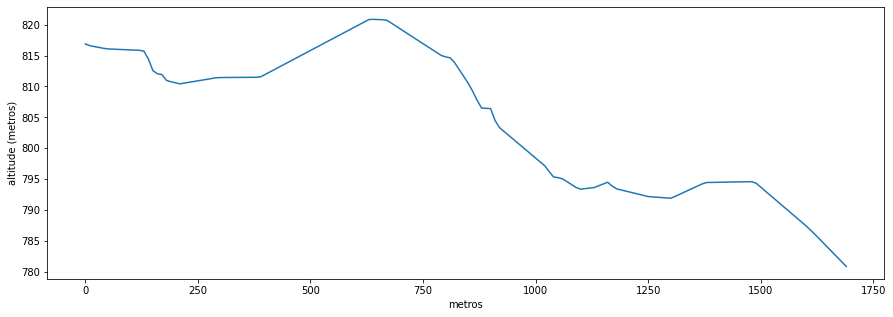

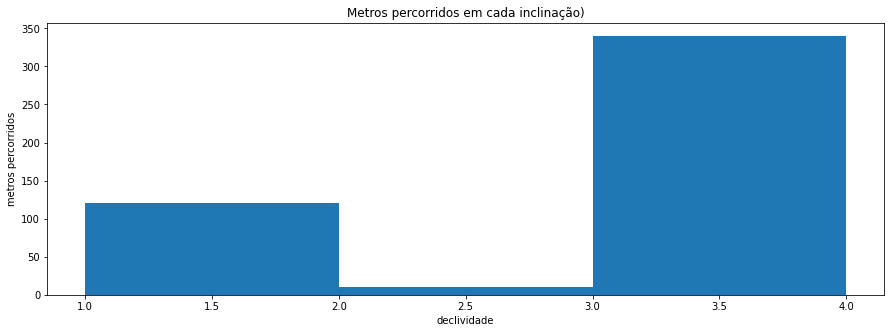

Distance potential:     0.718690074437995 	Distance:  1697.1771040252052
Age potential:          0.10948570881602325 	Age:       3
Inclination potential:  0.8847435546789131

Gender:
1 = M, 2 = F            2


In [9]:
plot_route_potential (18650)
#[74750, 63850, 41500, 102550, 43650, 123450, 76450, 24500]